# Problem Statement

Predicting the survival of the people on the Titanic. 

Kaggle : https://www.kaggle.com/c/titanic/data 

In [254]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , GridSearchCV ,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB , BernoulliNB ,MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
%matplotlib inline

In [147]:
df = pd.read_csv('Train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA

In [148]:
df.shape

(891, 12)

* There are 891 rows and 12 features

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* There are Null values in Age and Cabin.
* PClass, SibSp, ParCh reffered as int conveting them to Object

In [150]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [151]:
class style:
#These are the ANSI escape sequences to set Graphics in our output
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   BLINK = '\033[5m'
   END = '\033[0m'

#### Missing Values

In [152]:
missing_df = pd.DataFrame({'count': df.isna().sum(),'percentage':(df.isna().sum()/len(df))*100})
missing_df.sort_values(by='percentage',ascending=False)

,count,percentage
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


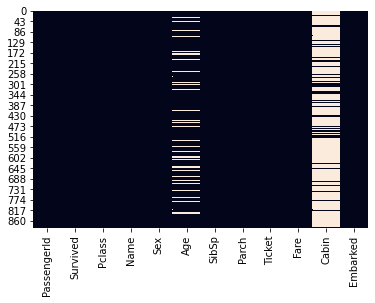

In [153]:
sns.heatmap(df.isna(),cbar=False)
plt.show()

* As Cabin has 77% of missing values imputing such data can be a biased decision, going forward dropping feature Cabin.
* Age has close to 20% of missing, will be imputing Age with appropriate techniques.

In [154]:
df=df.dropna(subset=['Embarked'])

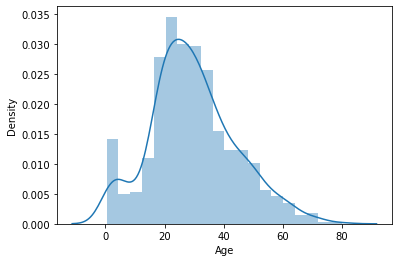

In [155]:
sns.distplot(df['Age'])
plt.show()

In [156]:
df['Age'].describe()

count    712.000000
mean      29.642093
std       14.492933
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [157]:
def impute(df,variable,median):
    df[variable+'_median'] = df[variable].fillna(median)
    df[variable+'_random'] = df[variable]
    sample = df[variable].dropna().sample(df[variable].isna().sum(),random_state=0)
    sample.index = df[df[variable].isna()].index
    df.loc[df[variable].isna(),variable+'_random']=sample

In [158]:
impute(df,'Age',df.Age.median())

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_median,Age_random
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,35.0


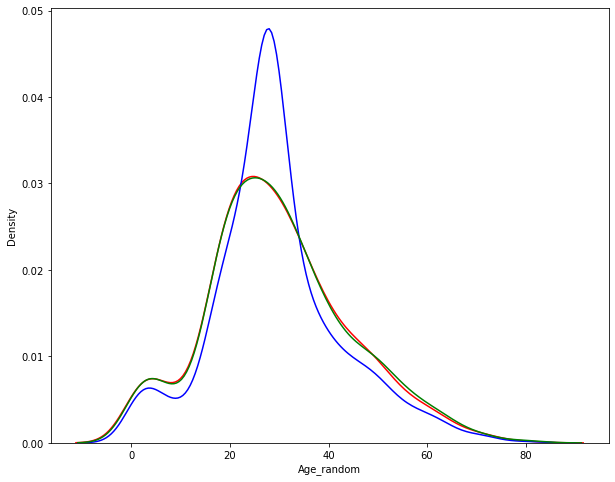

In [159]:
plt.figure(figsize=(10,8))
sns.distplot(df['Age'].dropna(),hist=False,color='red')
sns.distplot(df['Age_median'].dropna(),hist=False,color='blue')
sns.distplot(df['Age_random'].dropna(),hist=False,color='green')
plt.show()

In [196]:
df_model = df.drop(['Age','Age_median','Cabin'],1)
df_model.reset_index(inplace=True,drop=True)
df_model

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked,Age_random
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,S,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,S,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,S,35.0
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,S,35.0
...,...,...,...,...,...,...,...,...,...,...,...
884,887,0,2,"Montvila, Rev. Juozas",male,0,0,211536,13.0000,S,27.0
885,888,1,1,"Graham, Miss. Margaret Edith",female,0,0,112053,30.0000,S,19.0
886,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,1,2,W./C. 6607,23.4500,S,58.0
887,890,1,1,"Behr, Mr. Karl Howell",male,0,0,111369,30.0000,C,26.0


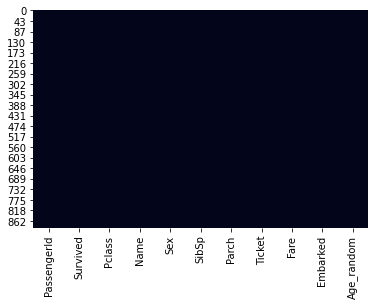

In [161]:
sns.heatmap(df_model.isna(),cbar=False)
plt.show()

* Treated all the missing values with appropriate techniques

In [162]:
df[['Pclass','SibSp','Parch','Survived']] = df[['Pclass','SibSp','Parch','Survived']].astype('O')

In [163]:
df.dtypes

PassengerId      int64
Survived        object
Pclass          object
Name            object
Sex             object
Age            float64
SibSp           object
Parch           object
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Age_median     float64
Age_random     float64
dtype: object

In [164]:
df_num = df.select_dtypes(include=np.number)
df_cat = df.select_dtypes(exclude=np.number)

for i in df_cat.drop(['Name','Ticket','Cabin'],1).columns:
    res= pd.DataFrame()
    res=pd.DataFrame({'Counts':df_cat[i].value_counts(),'Percentage':df_cat[i].value_counts(normalize=True)*100})
    print(i)
    print(res)
    print('\n')

Survived
   Counts  Percentage
0     549   61.754781
1     340   38.245219


Pclass
   Counts  Percentage
3     491   55.230596
1     214   24.071991
2     184   20.697413


Sex
        Counts  Percentage
male       577   64.904387
female     312   35.095613


SibSp
   Counts  Percentage
0     606   68.166479
1     209   23.509561
2      28    3.149606
4      18    2.024747
3      16    1.799775
8       7    0.787402
5       5    0.562430


Parch
   Counts  Percentage
0     676   76.040495
1     118   13.273341
2      80    8.998875
3       5    0.562430
5       5    0.562430
4       4    0.449944
6       1    0.112486


Embarked
   Counts  Percentage
S     644   72.440945
C     168   18.897638
Q      77    8.661417




## Univariate Analysis

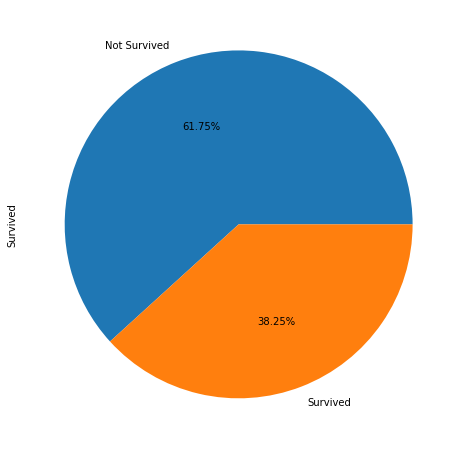

In [165]:
plt.figure(figsize=(10,8))
df['Survived'].value_counts().plot(kind='pie',autopct='%0.2f%%',explode=[0.0,0.0],labels=['Not Survived','Survived'])
plt.show()

* There are 62% of the passengers are not survived and 38% are survived.

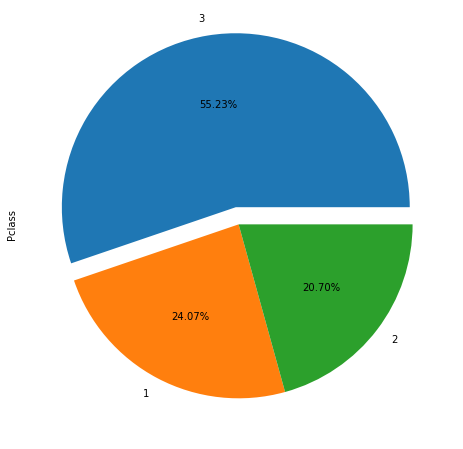

In [166]:
plt.figure(figsize=(10,8))
df['Pclass'].value_counts().plot(kind='pie',autopct='%0.2f%%',explode=[0.1,0.0,0.0])
plt.show()

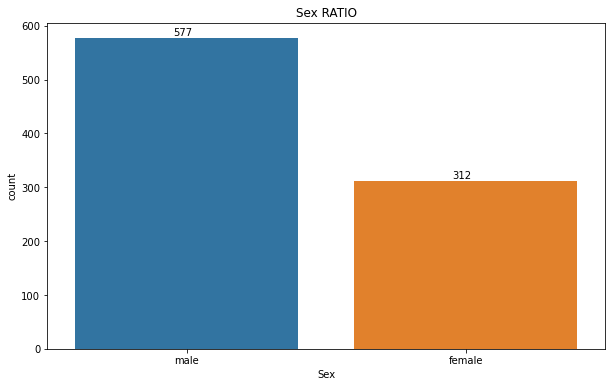

In [167]:
plt.figure(figsize=(10,6))
ax=sns.countplot(df['Sex'])
plt.title('Sex RATIO')
for i in ax.patches:
    ax.annotate('{}'.format(i.get_height()),(i.get_x()+0.35,i.get_height()+5),color='black')

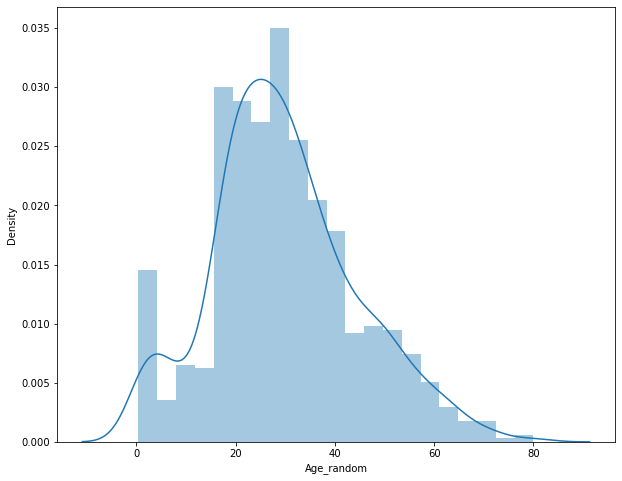

In [168]:
plt.figure(figsize=(10,8))
sns.distplot(df['Age_random'])
plt.show()

# Bivariate Analysis:

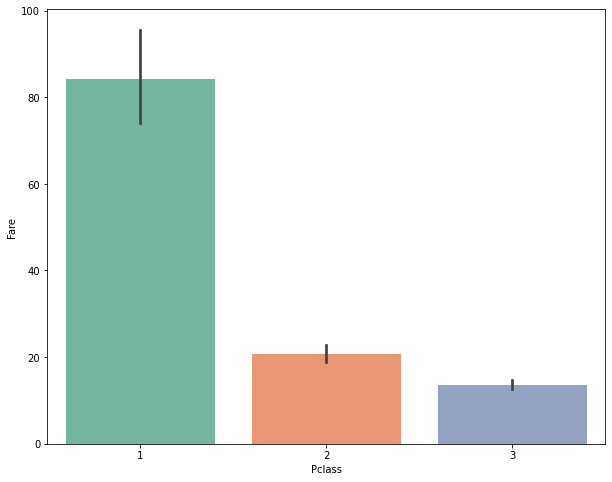

In [169]:
plt.figure(figsize=(10,8))
sns.barplot(df_model['Pclass'],df_model['Fare'],palette='Set2')
plt.show()

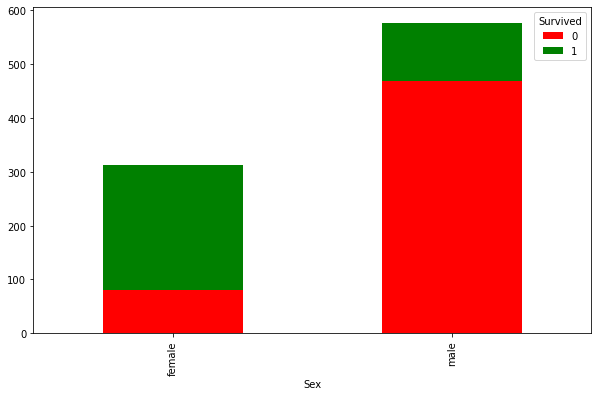

In [170]:
pd.crosstab(df_model['Sex'],df_model['Survived']).plot(kind='bar',stacked=True,color='rg',figsize=(10,6))
plt.show()

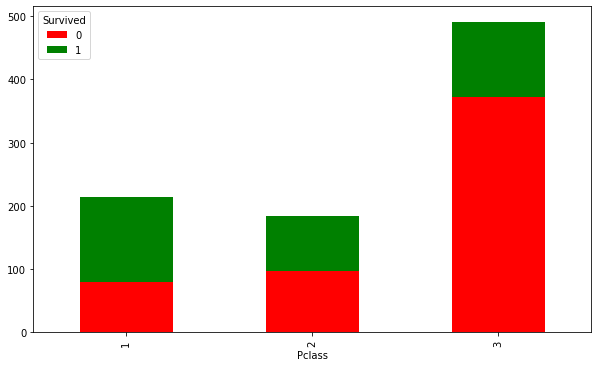

In [171]:
pd.crosstab(df_model['Pclass'],df_model['Survived']).plot(kind='bar',stacked=True,color='rg',figsize=(10,6))
plt.show()

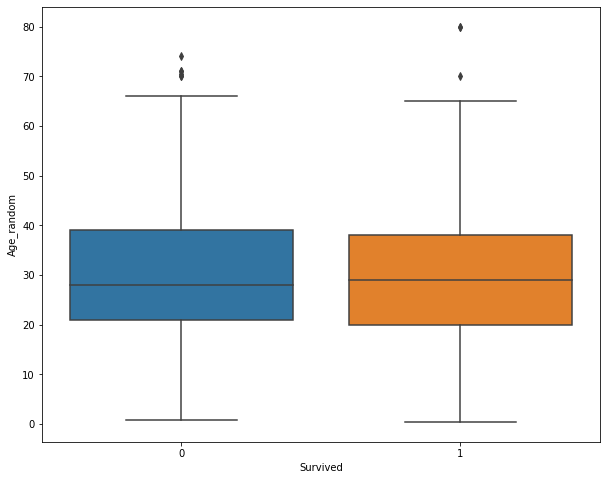

In [172]:
plt.figure(figsize=(10,8))
sns.boxplot(df_model['Survived'],df_model['Age_random'])
plt.show()

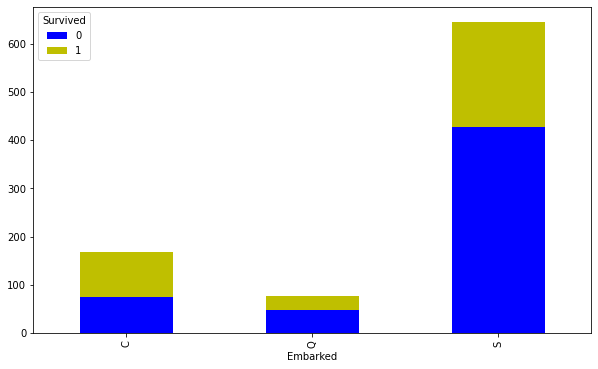

In [173]:
pd.crosstab(df_model['Embarked'],df_model['Survived']).plot(kind='bar',stacked=True,color='by',figsize=(10,6))
plt.show()

## Multivariate Analysis

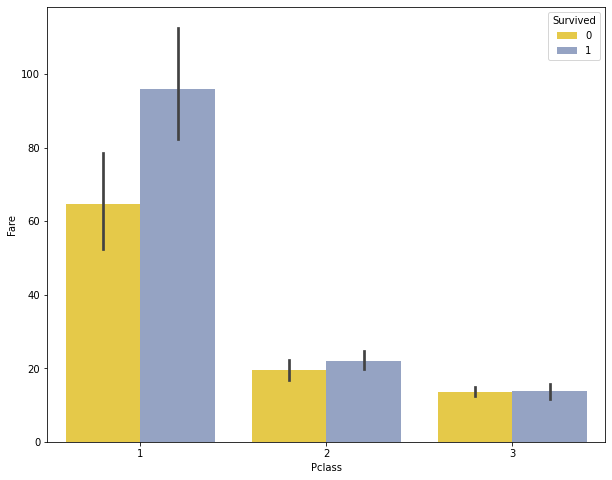

In [174]:
plt.figure(figsize=(10,8))
sns.barplot(df_model['Pclass'],df_model['Fare'],hue='Survived',data=df_model,palette='Set2_r')
plt.show()

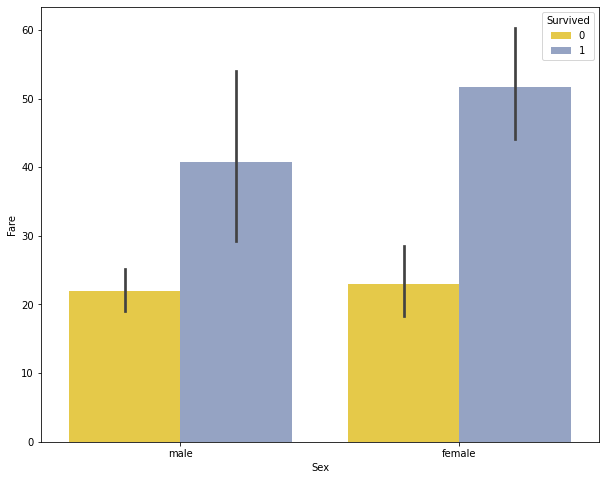

In [175]:
plt.figure(figsize=(10,8))
sns.barplot(df_model['Sex'],df_model['Fare'],hue='Survived',data=df_model,palette='Set2_r')
plt.show()

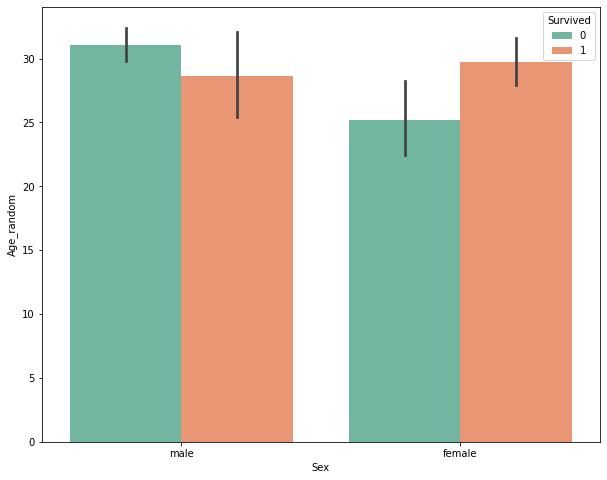

In [176]:
plt.figure(figsize=(10,8))
sns.barplot(df_model['Sex'],df_model['Age_random'],hue='Survived',data=df_model,palette='Set2')
plt.show()

# Feature Selection:

In [197]:
df_model[['Pclass','SibSp','Parch','Survived']] = df_model[['Pclass','SibSp','Parch','Survived']].astype('O')

In [198]:
df_final = df_model.drop(['PassengerId','Name','Ticket'],1)

df_encoded = pd.get_dummies(df_final,drop_first=True)

df_encoded=df_encoded.rename(columns={'Survived_1':'Survived'})

df_encoded

,Fare,Age_random,Survived,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,7.2500,22.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,71.2833,38.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7.9250,26.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,53.1000,35.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,8.0500,35.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,13.0000,27.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
885,30.0000,19.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
886,23.4500,58.0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
887,30.0000,26.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [199]:
X = df_encoded.drop('Survived',1)
y = df_encoded['Survived']

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=10)

print('x train shape:',x_train.shape)
print('x test shape:',x_test.shape)
print('y train shape:',y_train.shape)
print('y test shape:',y_test.shape)

x train shape: (711, 19)
x test shape: (178, 19)
y train shape: (711,)
y test shape: (178,)


# Model Building:

In [200]:
def evaluation_metric(model):
    model = model.fit(x_train,y_train)
    ypred_test = model.predict(x_test)
    ypred_train = model.predict(x_train)
    print(f"{style.BOLD}{model}{style.END}")
    print('-------------------------------------------------')
    print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
    print('-------------------------------------------------')
    print(classification_report(y_train,ypred_train))
    print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
    print('-------------------------------------------------')
    print(confusion_matrix(y_train,ypred_train))
    print('\n')
    print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
    print('-------------------------------------------------')
    print(classification_report(y_test,ypred_test))
    print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
    print('-------------------------------------------------')
    print(confusion_matrix(y_test,ypred_test))

In [201]:
score_card = pd.DataFrame(columns=['Model_Name', 'Train Accuracy', 'Train F1-Weighted Average','Test Accuracy','Test F1-Weighted Average'])
score_card

,Model_Name,Train Accuracy,Train F1-Weighted Average,Test Accuracy,Test F1-Weighted Average


### Logistic Regression Model

In [202]:
Logistic = LogisticRegression()
evaluation_metric(Logistic)

LogisticRegression()
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       434
           1       0.77      0.69      0.73       277

    accuracy                           0.80       711
   macro avg       0.79      0.78      0.78       711
weighted avg       0.80      0.80      0.80       711

Confusion Matrix
-------------------------------------------------
[[376  58]
 [ 86 191]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       115
           1       0.77      0.68      0.72        63

    accuracy                           0.81       178
   macro avg       0.80      0.78      0.79       178
weighted avg       0.81      0.81      0.81       178

Confusion 

In [203]:
logistic = pd.Series({'Model_Name':'Logistic Regression',
                                'Train Accuracy': '80%',
                                'Train F1-Weighted Average': '80%',
                                'Test Accuracy': '81%',
                                'Test F1-Weighted Average':'81%'
                               })

score_card=score_card.append(logistic,ignore_index=True)

score_card

,Model_Name,Train Accuracy,Train F1-Weighted Average,Test Accuracy,Test F1-Weighted Average
0,Logistic Regression,80%,80%,81%,81%


### Decision Tree Model

In [204]:
dt = DecisionTreeClassifier()
evaluation_metric(dt)

DecisionTreeClassifier()
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       434
           1       1.00      0.96      0.98       277

    accuracy                           0.98       711
   macro avg       0.99      0.98      0.98       711
weighted avg       0.98      0.98      0.98       711

Confusion Matrix
-------------------------------------------------
[[434   0]
 [ 11 266]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       115
           1       0.64      0.68      0.66        63

    accuracy                           0.75       178
   macro avg       0.73      0.74      0.73       178
weighted avg       0.76      0.75      0.75       178

Confus

In [205]:
decision_tree = pd.Series({'Model_Name':'Decision Tree',
                                'Train Accuracy': '98%',
                                'Train F1-Weighted Average': '98%',
                                'Test Accuracy': '75%',
                                'Test F1-Weighted Average':'75%'
                               })

score_card=score_card.append(decision_tree,ignore_index=True)

score_card

,Model_Name,Train Accuracy,Train F1-Weighted Average,Test Accuracy,Test F1-Weighted Average
0,Logistic Regression,80%,80%,81%,81%
1,Decision Tree,98%,98%,75%,75%


### KNN Model

In [207]:
sc = StandardScaler()
x_sc = df_encoded[['Age_random','Fare']]

df_sc = pd.DataFrame(sc.fit_transform(x_sc),columns=x_sc.columns)

df1 = df_encoded.drop(['Age_random','Fare'],1)

df_scaled = pd.concat([df_sc,df1],1)

df_scaled

,Age_random,Fare,Survived,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,-0.537500,-0.500240,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.554413,0.788947,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.264522,-0.486650,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.349679,0.422861,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.349679,-0.484133,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,-0.196277,-0.384475,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
885,-0.742234,-0.042213,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
886,1.919304,-0.174084,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
887,-0.264522,-0.042213,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [209]:
X_sc = df_scaled.drop('Survived',1)
y_sc = df_scaled['Survived']

x_train_sc,x_test_sc,y_train_sc,y_test_sc = train_test_split(X_sc,y_sc,test_size=0.2,random_state=10)

print('x train shape:',x_train_sc.shape)
print('x test shape:',x_test_sc.shape)
print('y train shape:',y_train_sc.shape)
print('y test shape:',y_test_sc.shape)

x train shape: (711, 19)
x test shape: (178, 19)
y train shape: (711,)
y test shape: (178,)


In [211]:
kn = KNeighborsClassifier()
model = kn.fit(x_train_sc,y_train_sc)
ypred_test = model.predict(x_test_sc)
ypred_train = model.predict(x_train_sc)
print(f"{style.BOLD}{model}{style.END}")
print('-------------------------------------------------')
print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_train_sc,ypred_train))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_train_sc,ypred_train))
print('\n')
print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_test_sc,ypred_test))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_test_sc,ypred_test))

KNeighborsClassifier()
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.91      0.87       434
           1       0.83      0.74      0.78       277

    accuracy                           0.84       711
   macro avg       0.84      0.82      0.83       711
weighted avg       0.84      0.84      0.84       711

Confusion Matrix
-------------------------------------------------
[[393  41]
 [ 72 205]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       115
           1       0.76      0.71      0.74        63

    accuracy                           0.82       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.82      0.82      0.82       178

Confusio

In [212]:
knn = pd.Series({'Model_Name':'KNeighborsClassifier',
                                'Train Accuracy': '84%',
                                'Train F1-Weighted Average': '84%',
                                'Test Accuracy': '82%',
                                'Test F1-Weighted Average':'82%'
                               })

score_card=score_card.append(knn,ignore_index=True)

score_card

,Model_Name,Train Accuracy,Train F1-Weighted Average,Test Accuracy,Test F1-Weighted Average
0,Logistic Regression,80%,80%,81%,81%
1,Decision Tree,98%,98%,75%,75%
2,KNeighborsClassifier,84%,84%,82%,82%


### Bernoulli NB

In [219]:
bb = BernoulliNB()
evaluation_metric(bb)

BernoulliNB()
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       434
           1       0.76      0.68      0.72       277

    accuracy                           0.79       711
   macro avg       0.78      0.77      0.77       711
weighted avg       0.79      0.79      0.79       711

Confusion Matrix
-------------------------------------------------
[[375  59]
 [ 90 187]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       115
           1       0.73      0.70      0.72        63

    accuracy                           0.80       178
   macro avg       0.79      0.78      0.78       178
weighted avg       0.80      0.80      0.80       178

Confusion Matrix


In [220]:
bb_model = pd.Series({'Model_Name':'BernoulliNB',
                                'Train Accuracy': '79%',
                                'Train F1-Weighted Average': '79%',
                                'Test Accuracy': '80%',
                                'Test F1-Weighted Average':'80%'
                               })

score_card=score_card.append(bb_model,ignore_index=True)

score_card

,Model_Name,Train Accuracy,Train F1-Weighted Average,Test Accuracy,Test F1-Weighted Average
0,Logistic Regression,80%,80%,81%,81%
1,Decision Tree,98%,98%,75%,75%
2,KNeighborsClassifier,84%,84%,82%,82%
3,BernoulliNB,79%,79%,80%,80%


### HyperParameter Tuning

In [224]:
tune_dt = [{'criterion':['gini','entropy'],
        'max_depth':[2,3,4,5]}]

tune_knn = [{'n_neighbors':[2,3,4,5,6],
            'weights':['uniform','distance'],
            'p':[1,2,3]}]

kn = KNeighborsClassifier()
dt = DecisionTreeClassifier()

gv_dt = GridSearchCV(estimator=dt,param_grid=tune_dt,scoring='f1_weighted',cv=5)
model_gdt = gv_dt.fit(x_train,y_train)
print('Best Decision tree parameters:',model_gdt.best_params_)
print('\n')

gv_knn = GridSearchCV(estimator=kn,param_grid=tune_knn,scoring='f1_weighted',cv=5)
model_gkn = gv_knn.fit(x_train_sc,y_train_sc)
print('Best KNN parameters:',model_gkn.best_params_)

Best Decision tree parameters: {'criterion': 'entropy', 'max_depth': 4}


Best KNN parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


### Tuned Models:

#### Decision Tree

In [225]:
dt_tuned = DecisionTreeClassifier(criterion='entropy',max_depth=4)
evaluation_metric(dt_tuned)

DecisionTreeClassifier(criterion='entropy', max_depth=4)
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       434
           1       0.90      0.61      0.73       277

    accuracy                           0.82       711
   macro avg       0.85      0.78      0.80       711
weighted avg       0.84      0.82      0.81       711

Confusion Matrix
-------------------------------------------------
[[415  19]
 [107 170]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       115
           1       0.85      0.65      0.74        63

    accuracy                           0.84       178
   macro avg       0.84      0.79      0.81       178
weighted avg       0.84      

In [227]:
tunned_dt_model = pd.Series({'Model_Name':'Tuned Decision Tree',
                                'Train Accuracy': '82%',
                                'Train F1-Weighted Average': '81%',
                                'Test Accuracy': '84%',
                                'Test F1-Weighted Average':'83%'
                               })

score_card=score_card.append(tunned_dt_model,ignore_index=True)

score_card

,Model_Name,Train Accuracy,Train F1-Weighted Average,Test Accuracy,Test F1-Weighted Average
0,Logistic Regression,80%,80%,81%,81%
1,Decision Tree,98%,98%,75%,75%
2,KNeighborsClassifier,84%,84%,82%,82%
3,BernoulliNB,79%,79%,80%,80%
4,Tuned Decision Tree,82%,81%,84%,83%


#### KNN

In [226]:
kn = KNeighborsClassifier(n_neighbors=5,p=1,weights='uniform')
model = kn.fit(x_train_sc,y_train_sc)
ypred_test = model.predict(x_test_sc)
ypred_train = model.predict(x_train_sc)
print(f"{style.BOLD}{model}{style.END}")
print('-------------------------------------------------')
print(f"{style.BOLD}{'Classification Report for Train Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_train_sc,ypred_train))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_train_sc,ypred_train))
print('\n')
print(f"{style.BOLD}{'Classification Report For Test Data'}{style.END}")
print('-------------------------------------------------')
print(classification_report(y_test_sc,ypred_test))
print(f"{style.BOLD}{'Confusion Matrix'}{style.END}")
print('-------------------------------------------------')
print(confusion_matrix(y_test_sc,ypred_test))

KNeighborsClassifier(p=1)
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       434
           1       0.84      0.74      0.79       277

    accuracy                           0.85       711
   macro avg       0.85      0.83      0.83       711
weighted avg       0.85      0.85      0.84       711

Confusion Matrix
-------------------------------------------------
[[396  38]
 [ 71 206]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       115
           1       0.79      0.78      0.78        63

    accuracy                           0.85       178
   macro avg       0.83      0.83      0.83       178
weighted avg       0.85      0.85      0.85       178

Confu

In [228]:
tuned_knn = pd.Series({'Model_Name':'Tuned KNN',
                                'Train Accuracy': '85%',
                                'Train F1-Weighted Average': '84%',
                                'Test Accuracy': '85%',
                                'Test F1-Weighted Average':'85%'
                               })

score_card=score_card.append(tuned_knn,ignore_index=True)

score_card

,Model_Name,Train Accuracy,Train F1-Weighted Average,Test Accuracy,Test F1-Weighted Average
0,Logistic Regression,80%,80%,81%,81%
1,Decision Tree,98%,98%,75%,75%
2,KNeighborsClassifier,84%,84%,82%,82%
3,BernoulliNB,79%,79%,80%,80%
4,Tuned Decision Tree,82%,81%,84%,83%
5,Tuned KNN,85%,84%,85%,85%


### Ensemble Models

#### Bagging With KNN

In [232]:
knn = KNeighborsClassifier()
bg = BaggingClassifier(base_estimator=knn , n_estimators=10)
evaluation_metric(bg)

BaggingClassifier(base_estimator=KNeighborsClassifier())
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.89      0.83       434
           1       0.78      0.62      0.69       277

    accuracy                           0.78       711
   macro avg       0.78      0.76      0.76       711
weighted avg       0.78      0.78      0.78       711

Confusion Matrix
-------------------------------------------------
[[385  49]
 [104 173]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       115
           1       0.55      0.43      0.48        63

    accuracy                           0.67       178
   macro avg       0.64      0.62      0.62       178
weighted avg       0.66      

In [238]:
tuned_knn_bg = pd.Series({'Model_Name':'Bagging KNN',
                                'Train Accuracy': '78%',
                                'Train F1-Weighted Average': '78%',
                                'Test Accuracy': '67%',
                                'Test F1-Weighted Average':'66%'
                               })

score_card=score_card.append(tuned_knn_bg,ignore_index=True)

score_card

,Model_Name,Train Accuracy,Train F1-Weighted Average,Test Accuracy,Test F1-Weighted Average
0,Logistic Regression,80%,80%,81%,81%
1,Decision Tree,98%,98%,75%,75%
2,KNeighborsClassifier,84%,84%,82%,82%
3,BernoulliNB,79%,79%,80%,80%
4,Tuned Decision Tree,82%,81%,84%,83%
5,Tuned KNN,85%,84%,85%,85%
6,Bagging KNN,78%,78%,67%,66%


#### Random Forest

In [235]:
rf = RandomForestClassifier()

evaluation_metric(rf)

RandomForestClassifier()
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       434
           1       0.99      0.97      0.98       277

    accuracy                           0.98       711
   macro avg       0.99      0.98      0.98       711
weighted avg       0.98      0.98      0.98       711

Confusion Matrix
-------------------------------------------------
[[432   2]
 [  9 268]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       115
           1       0.74      0.76      0.75        63

    accuracy                           0.82       178
   macro avg       0.80      0.81      0.80       178
weighted avg       0.82      0.82      0.82       178

Confus

In [237]:
tune_dt = [{'criterion':['gini','entropy'],
        'max_depth':[2,3,4,5],
           'n_estimators':[20,50,100,150,200]}]

rf = RandomForestClassifier()

gv_rf = GridSearchCV(estimator=rf,param_grid=tune_dt,scoring='f1_weighted',cv=5)
model_gdt = gv_rf.fit(x_train,y_train)
print('Best Random Forest  parameters:',model_gdt.best_params_)
print('\n')

Best Random Forest  parameters: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 50}




In [239]:
rf_tuned = RandomForestClassifier(n_estimators=50,criterion='entropy',max_depth=5)

evaluation_metric(rf_tuned)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=50)
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       434
           1       0.92      0.63      0.75       277

    accuracy                           0.84       711
   macro avg       0.86      0.80      0.81       711
weighted avg       0.85      0.84      0.83       711

Confusion Matrix
-------------------------------------------------
[[419  15]
 [102 175]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.95      0.88       115
           1       0.87      0.63      0.73        63

    accuracy                           0.84       178
   macro avg       0.85      0.79      0.81       178
weighted avg

In [240]:
tuned_rf = pd.Series({'Model_Name':'Tuned Random Forest',
                                'Train Accuracy': '84%',
                                'Train F1-Weighted Average': '83%',
                                'Test Accuracy': '84%',
                                'Test F1-Weighted Average':'83%'
                               })

score_card=score_card.append(tuned_rf,ignore_index=True)

score_card

,Model_Name,Train Accuracy,Train F1-Weighted Average,Test Accuracy,Test F1-Weighted Average
0,Logistic Regression,80%,80%,81%,81%
1,Decision Tree,98%,98%,75%,75%
2,KNeighborsClassifier,84%,84%,82%,82%
3,BernoulliNB,79%,79%,80%,80%
4,Tuned Decision Tree,82%,81%,84%,83%
5,Tuned KNN,85%,84%,85%,85%
6,Bagging KNN,78%,78%,67%,66%
7,Tuned Random Forest,84%,83%,84%,83%


#### Ada Boosting

In [243]:
ad = AdaBoostClassifier()

evaluation_metric(ad)

AdaBoostClassifier()
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       434
           1       0.77      0.74      0.76       277

    accuracy                           0.82       711
   macro avg       0.81      0.80      0.80       711
weighted avg       0.81      0.82      0.82       711

Confusion Matrix
-------------------------------------------------
[[374  60]
 [ 71 206]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       115
           1       0.75      0.78      0.77        63

    accuracy                           0.83       178
   macro avg       0.81      0.82      0.82       178
weighted avg       0.83      0.83      0.83       178

Confusion 

In [246]:
ada_boost = pd.Series({'Model_Name':'Ada Boost',
                                'Train Accuracy': '82%',
                                'Train F1-Weighted Average': '82%',
                                'Test Accuracy': '83%',
                                'Test F1-Weighted Average':'83%'
                               })

score_card=score_card.append(ada_boost,ignore_index=True)

score_card

,Model_Name,Train Accuracy,Train F1-Weighted Average,Test Accuracy,Test F1-Weighted Average
0,Logistic Regression,80%,80%,81%,81%
1,Decision Tree,98%,98%,75%,75%
2,KNeighborsClassifier,84%,84%,82%,82%
3,BernoulliNB,79%,79%,80%,80%
4,Tuned Decision Tree,82%,81%,84%,83%
5,Tuned KNN,85%,84%,85%,85%
6,Bagging KNN,78%,78%,67%,66%
7,Tuned Random Forest,84%,83%,84%,83%
8,Ada Boost,82%,82%,83%,83%


#### GradientBoostingClassifier

In [244]:
gbc = GradientBoostingClassifier()

evaluation_metric(gbc)

GradientBoostingClassifier()
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       434
           1       0.93      0.78      0.85       277

    accuracy                           0.89       711
   macro avg       0.90      0.87      0.88       711
weighted avg       0.89      0.89      0.89       711

Confusion Matrix
-------------------------------------------------
[[417  17]
 [ 60 217]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       115
           1       0.84      0.75      0.79        63

    accuracy                           0.86       178
   macro avg       0.85      0.83      0.84       178
weighted avg       0.86      0.86      0.86       178

Co

In [256]:
gb_c= GradientBoostingClassifier()
cross_val = cross_val_score(estimator=gb_c,X=x_train,y=y_train,scoring='f1_weighted',cv=10)
bais = (1 - np.mean(cross_val))
variance = np.std(cross_val)/np.mean(cross_val)

print(f"{style.BOLD}Bais Error")
print('--------------------------')
print(bais)
print('\n')
print(f"{style.BOLD}Variance Error")
print('--------------------------')
print(variance)

Bais Error
--------------------------
0.2018387550040035


Variance Error
--------------------------
0.06972370217127934


In [247]:
gb_boost = pd.Series({'Model_Name':'GradientBoosting',
                                'Train Accuracy': '89%',
                                'Train F1-Weighted Average': '89%',
                                'Test Accuracy': '86%',
                                'Test F1-Weighted Average':'86%'
                               })

score_card=score_card.append(gb_boost,ignore_index=True)

score_card

,Model_Name,Train Accuracy,Train F1-Weighted Average,Test Accuracy,Test F1-Weighted Average
0,Logistic Regression,80%,80%,81%,81%
1,Decision Tree,98%,98%,75%,75%
2,KNeighborsClassifier,84%,84%,82%,82%
3,BernoulliNB,79%,79%,80%,80%
4,Tuned Decision Tree,82%,81%,84%,83%
5,Tuned KNN,85%,84%,85%,85%
6,Bagging KNN,78%,78%,67%,66%
7,Tuned Random Forest,84%,83%,84%,83%
8,Ada Boost,82%,82%,83%,83%
9,GradientBoosting,89%,89%,86%,86%


#### XGBoost

In [245]:
xb = XGBClassifier()

evaluation_metric(xb)

[18:31:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
-------------------------------------------------
Classification Report for Train Data
---------------------

In [248]:
xb_boost = pd.Series({'Model_Name':'XGBoost',
                                'Train Accuracy': '97%',
                                'Train F1-Weighted Average': '97%',
                                'Test Accuracy': '81%',
                                'Test F1-Weighted Average':'81%'
                               })

score_card=score_card.append(xb_boost,ignore_index=True)

score_card

,Model_Name,Train Accuracy,Train F1-Weighted Average,Test Accuracy,Test F1-Weighted Average
0,Logistic Regression,80%,80%,81%,81%
1,Decision Tree,98%,98%,75%,75%
2,KNeighborsClassifier,84%,84%,82%,82%
3,BernoulliNB,79%,79%,80%,80%
4,Tuned Decision Tree,82%,81%,84%,83%
5,Tuned KNN,85%,84%,85%,85%
6,Bagging KNN,78%,78%,67%,66%
7,Tuned Random Forest,84%,83%,84%,83%
8,Ada Boost,82%,82%,83%,83%
9,GradientBoosting,89%,89%,86%,86%


In [251]:
svc = SVC(kernel='linear')
evaluation_metric(svc)

SVC(kernel='linear')
-------------------------------------------------
Classification Report for Train Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       434
           1       0.78      0.67      0.72       277

    accuracy                           0.80       711
   macro avg       0.79      0.77      0.78       711
weighted avg       0.79      0.80      0.79       711

Confusion Matrix
-------------------------------------------------
[[381  53]
 [ 92 185]]


Classification Report For Test Data
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       115
           1       0.80      0.65      0.72        63

    accuracy                           0.82       178
   macro avg       0.82      0.78      0.79       178
weighted avg       0.82      0.82      0.82       178

Confusion 

In [252]:
svc_model = pd.Series({'Model_Name':'Support Vector Machine',
                                'Train Accuracy': '80%',
                                'Train F1-Weighted Average': '79%',
                                'Test Accuracy': '82%',
                                'Test F1-Weighted Average':'82%'
                               })

score_card=score_card.append(svc_model,ignore_index=True)

score_card

,Model_Name,Train Accuracy,Train F1-Weighted Average,Test Accuracy,Test F1-Weighted Average
0,Logistic Regression,80%,80%,81%,81%
1,Decision Tree,98%,98%,75%,75%
2,KNeighborsClassifier,84%,84%,82%,82%
3,BernoulliNB,79%,79%,80%,80%
4,Tuned Decision Tree,82%,81%,84%,83%
5,Tuned KNN,85%,84%,85%,85%
6,Bagging KNN,78%,78%,67%,66%
7,Tuned Random Forest,84%,83%,84%,83%
8,Ada Boost,82%,82%,83%,83%
9,GradientBoosting,89%,89%,86%,86%


# Conclusion:

**Above score card depicts the performance of all the models tried on train data.**

**Out of which Gradient boosting model gives us better performance on both train and test data.**

## Considering F1 score as preffered metric, Gradient boosing model as our best model for the given problem statement.

### TESTING DATA

In [261]:
testing = pd.read_csv('Cleaned_test.csv',index_col=0)
testing.head()

,Fare,Age_random,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,7.8292,34.5,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,7.0000,47.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,9.6875,62.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,8.6625,27.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,12.2875,22.0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1


In [262]:
gb = GradientBoostingClassifier()
model = model.fit(X,y)
ypred_test = model.predict(testing)
ypred_test

array([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,

In [263]:
result=pd.DataFrame(ypred_test, columns=['Survived'])
result.to_csv('result.csv')